In [47]:
from typing import TypedDict, Annotated, List, Dict, Optional

import operator


class FinancialData(TypedDict):
    ratios: Dict
    earnings_trend: str

class SentimentData(TypedDict):
    score: float
    summary: str
class InvestmentState(TypedDict):
    ticker: str
    messages: Annotated[List[str],operator.add]
    fundamental_data: Optional[FinancialData]
    Sentiment_data: Optional[SentimentData]
    current_step: str
    is_debated: bool


In [48]:
import yfinance as yf

In [49]:
import os
from dotenv import load_dotenv

# 1. Load the variables from .env into the environment
load_dotenv()

# 2. Retrieve the key
api_key = os.getenv("OPEN_API_KEY")

if not api_key:
    raise ValueError("API Key not found. Please set it in the .env file.")

print("Key loaded successfully!")

Key loaded successfully!


In [50]:
###{'pe_ratio': 33.4488, 'debt_to_equity': 102.63, 'revenue_growth': 0.157###

In [51]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

In [52]:
from langchain_community.tools import YahooFinanceNewsTool
from langchain.tools import tool
import yfinance as yf

@tool
# Define custom tools for the agent to use
def get_fundamental_metrics(ticker: str):
    """Fetches P/E, Debt-to-Equity, and Revenue Growth for a given ticker."""
    stock = yf.Ticker(ticker)
    info = stock.info
    
    return {
        "pe_ratio": info.get("trailingPE"),
        "debt_to_equity": info.get("debtToEquity"),
        "revenue_growth": info.get("revenueGrowth"),
    }

# Combine tools
tools = [get_fundamental_metrics]

from langchain_openai import ChatOpenAI

# Initialize the LLM with tool binding
llm = ChatOpenAI(model="gpt-4o",api_key=api_key).bind_tools(tools)
def fundamental_analyst_node(state :InvestmentState):
    ticker= state['ticker']

    prompt=f""" 
You are an expert Fundamental Analyst. Analyze the financial metrics for {ticker}

1. Use the 'get_fundamental_metrics' tool to retrieve current data.

2. Assess the financial health based on P/E and Debt/Equity.

3. Return a concise, structure analysis.


 """
    
    response= llm.invoke([("system", prompt),("human" , f"Analyze {ticker}")])

    if response.tool_calls:
    # 3. Execute the tool (yfinance logic)
        tool_name = response.tool_calls[0]["name"]
        tool_args = response.tool_calls[0]["args"]
    
    # Simple dispatcher
    if tool_name == "get_fundamental_metrics":
        tool_result = get_fundamental_metrics.invoke(tool_args)

        print(f"tools result {tool_result}")

        messages = [
            SystemMessage(content=prompt),
            HumanMessage(content=f"Analyze {ticker}"),
            response, # Pass the AIMessage object directly
            ToolMessage(
                tool_call_id=response.tool_calls[0]["id"],
                content=str(tool_result)
            )
        ]
        
    # 4. Invoke again with the full history
        final_response = llm.invoke(messages)
        print(final_response)

    else:
        print(response)


#fundamental_analyst_node('AAPL')

In [53]:
# Update your router node in agent.ipynb
def router(state: InvestmentState):
    # Logic to determine the next destination
    if not state.get("fundamental_data"):
        next_step = "fundamental_analyst"
    elif not state.get("sentiment_data"):
        next_step = "sentiment_analyst"
    else:
        next_step = "synthesis"
    
    # Return a dictionary to update the state.
    # This prevents the InvalidUpdateError.
    return {"current_step": next_step}

In [54]:
def route_after_supervisor(state: InvestmentState):
    # This returns the string that the conditional edges map uses
    return state["current_step"]

In [55]:
from langchain_community.tools import DuckDuckGoSearchRun

# Initialize the tool
search_tool = DuckDuckGoSearchRun()

def sentiment_analyst_node(state: InvestmentState):
    ticker = state["ticker"]
    
    # The tool automatically handles the search via DuckDuckGo
    results = search_tool.invoke(f"market sentiment and news for {ticker}")
    
    # ... then pass 'results' to your LLM for analysis
    return {"sentiment_analysis": {"summary": results}}

In [56]:
def synthesis_node(state: InvestmentState):
    """
    Acts as the 'Chief Investment Officer'. 
    Reads the Fundamental and Sentiment data and produces a final verdict.
    """
    # 1. Access both data sources
    fund_data = state.get("fundamental_analysis", {})
    sent_data = state.get("sentiment_analysis", {})
    
    # 2. Instruct the LLM to synthesize
    prompt = f"""
    You are the Chief Investment Officer. Synthesize this data for {state['ticker']}:
    Fundamental: {fund_data}
    Sentiment: {sent_data}
    
    Produce a final Buy/Sell/Hold recommendation with a clear rationale.
    """
    
    # 3. Generate report
    response = llm.invoke(prompt)
    
    return {
        "final_report": response.content,
        "messages": ["Synthesis Analyst: Final report generated."]
    }

In [57]:
from langgraph.graph import END, StateGraph

graph= StateGraph(InvestmentState)
graph.set_entry_point("supervisor")
graph.add_node("fundamental_analyst",fundamental_analyst_node)
graph.add_node("sentiment_analyst",sentiment_analyst_node)
graph.add_node("supervisor",router)
graph.add_node("synthesis",synthesis_node)



graph.add_conditional_edges(
    "supervisor",
    route_after_supervisor, # This reads the state update from the router node
    {
        "fundamental_analyst": "fundamental_analyst",
        "sentiment_analyst": "sentiment_analyst",
        "synthesis": "synthesis",
        "__end__": END
    })
graph.add_edge("fundamental_analyst", "supervisor")
graph.add_edge("sentiment_analyst", "supervisor")
graph.add_edge("synthesis", END)


app= graph.compile()

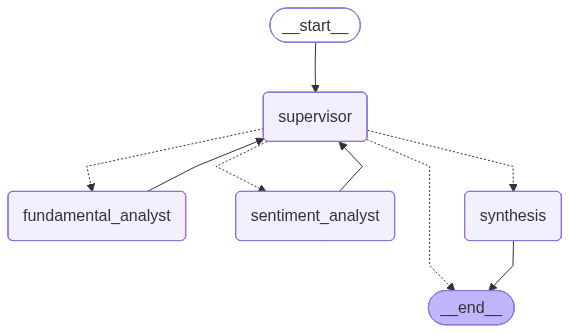

In [58]:
from IPython.display import Image, display

# You could see the errors with the below command
Image(app.get_graph().draw_mermaid_png())

In [59]:
# Define your initial input
input_data = {
    "ticker": "AAPL",
    "messages": [],
    "current_step": "supervisor", # Start at your entry point
    "is_debated": False
}

# Invoke the graph
final_state = app.invoke(input_data)

# Print the results
print("--- Final State ---")
print(f"Final Report/Step: {final_state['current_step']}")
print(f"Fundamental Data: {final_state.get('fundamental_data')}")

tools result {'pe_ratio': 33.651073, 'debt_to_equity': 102.63, 'revenue_growth': 0.157}
content="### Financial Analysis of AAPL\n\n1. **Price-to-Earnings (P/E) Ratio: 33.65**\n   - **Interpretation**: A P/E ratio of 33.65 suggests that investors are willing to pay $33.65 for every $1 of earnings, indicating expectations of strong future growth. However, this is relatively high, possibly signaling overvaluation or high growth anticipations compared to the broader market.\n\n2. **Debt-to-Equity Ratio: 102.63**\n   - **Interpretation**: This ratio exceeds 100, indicating that Apple uses a significant amount of debt to finance its operations. While this is not uncommon for large tech companies with stable cash flow, it still points to a reliance on leverage which could increase financial risk if not managed carefully.\n\n3. **Revenue Growth: 15.7%**\n   - **Interpretation**: A healthy revenue growth rate suggests robust business expansion and market demand. It supports the high P/E ratio, 

KeyboardInterrupt: 